In [1]:
import sys
import os
from pathlib import Path

REPO_PATH = r"C:\Users\tskor\Documents\GitHub\inovation_project\1_Code_Base" # Specify a local path to the repository (or use installed package instead)
os.environ["WANDB_DIR"] = r"C:\Users\tskor\Documents\GitHub\inovation_project\1_Code_Base"
sys.path.append(REPO_PATH)

PROJECT_ROOT = Path.cwd().parent.parent

from models.mlp import Mlp, mlp_data_preparation
from models.lstm import LstmWithAttention, lstm_data_preparation
from models.cnn import Cnn2D, cnn_data_preparation

import numpy as np
from data.test_train_split import test_train_split
import matplotlib.pyplot as plt
import tensorflow as tf
from models.utils import pen_low_loss
import wandb
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split

from data.test_train_split import test_train_split_multi_modal
from tensorflow.keras.utils import split_dataset

weather_dataset = r"C:\Users\tskor\Documents\data\WRF-HRRR\split_by_county_and_year\weather-combined.csv"
histograms_dataset = r"C:\Users\tskor\Documents\data\histograms\histograms_county_year\histograms-combined.npy"
labels = r"C:\Users\tskor\Documents\GitHub\inovation_project\2_Data\combined_labels_with_fips.npy"

#### Data preparation

In [2]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset_fips.npy"   
labels_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"



#### Linear regression

In [3]:
# Same dataset preparation as for MLP
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
x_train, x_test, y_train, y_test = train_test_split(mlp_dataset, labels, test_size=0.2, random_state=42)

lr = Ridge(alpha=1.0)
lr.fit(x_train, y_train)

#Evaluaation
lr_predictions = lr.predict(x_test)
lr_mse = sum((lr_predictions - y_test)**2) / len(y_test)
lr_mae = sum(abs(lr_predictions - y_test)) / len(y_test)

print(f"Linear regression RMSE: {np.sqrt(lr_mse)}")
print(f"Linear regression MAE: {lr_mae}")



Linear regression RMSE: [39.477818]
Linear regression MAE: [26.888323]


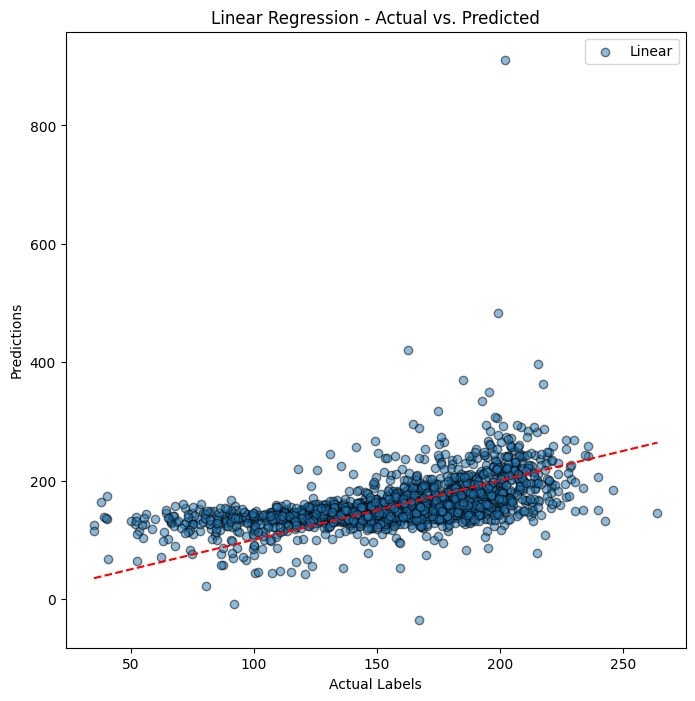


Correlations using scipy.stats.pearsonr:
Ridge regression correlation: 0.513 (p-value: 0.000e+00)
Mean of actual labels: 157.30


In [4]:
actual_labels = y_test

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lr_predictions, alpha=0.5, edgecolors='k', label="Linear")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Linear Regression - Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

lr_corr, lr_p = stats.pearsonr(actual_labels.flatten(), lr_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")

print(f"Ridge regression correlation: {lr_corr:.3f} (p-value: {lr_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")


#### MLP

In [9]:
mlp_dataset, labels = mlp_data_preparation(dataset_path, labels_path)
mlp_train_dataset, mlp_val_dataset, mlp_test_dataset = test_train_split(mlp_dataset,
                                                            labels,
                                                            **config_data)

In [29]:
mlp_dataset.shape

(9578, 1623)

Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 10824.6631 - mae: 84.1817 - mse: 10824.6631 - val_loss: 10695617536.0000 - val_mae: 2691.0129 - val_mse: 10695617536.0000
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 861.9719 - mae: 22.9387 - mse: 861.9719 - val_loss: 4194286592.0000 - val_mae: 1689.9485 - val_mse: 4194286592.0000
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 638.6919 - mae: 19.5830 - mse: 638.6919 - val_loss: 2966761984.0000 - val_mae: 1423.7900 - val_mse: 2966761984.0000
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 575.5632 - mae: 18.2120 - mse: 575.5632 - val_loss: 2337481216.0000 - val_mae: 1265.5962 - val_mse: 2337481216.0000
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 530.9708 - mae: 17.2442 - mse: 530.9708 - val_loss: 2069452544.0000 - val_mae: 1192.0996 - val_mse: 2069452544.0000
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 490.9774 - mae: 16.3294 - mse: 490.9774 - val_lo

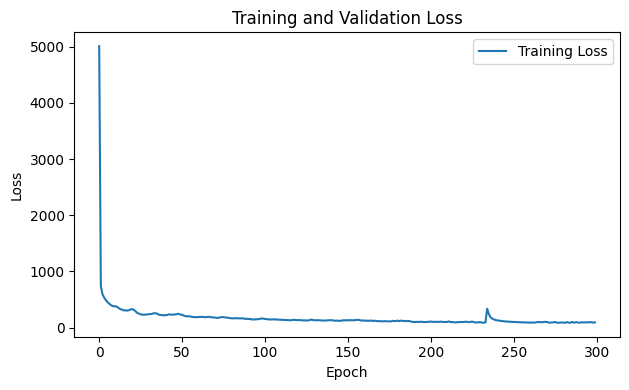

epoch/epoch,▁▁▂▂▂▂▂▃▃▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▁▁▃▁▁▁▁▁
epoch/mae,█▅▃▃▃▃▃▃▂▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁▁▁▁▂▂▁▁▁▁▁▁▁
epoch/mse,█▆▄▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▇▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▆▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mse,█▄▃▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,299
epoch/learning_rate,0.001
epoch/loss,92.20911


In [10]:

mlp_config = {
    "input_shape": (config_data["months"]
                  * config_data["num_buckets"]
                  * config_data["num_bands"],),
    "no_units": [100,] * 5,
}
mlp_model = Mlp(**mlp_config)
mlp_model.compile(learning_rate=0.00001, loss='mse', metrics=["mae", "mse"])
mlp_model.fit(mlp_train_dataset,
         mlp_val_dataset,
         epochs=300)

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model.trainable = False
wandb.finish()  

In [11]:
mlp_eval = mlp_model.evaluate(mlp_test_dataset)
print(mlp_eval)


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 682.6055 - mae: 19.8956 - mse: 682.6055
[703.0715942382812, 20.08078384399414, 703.0715942382812]


59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


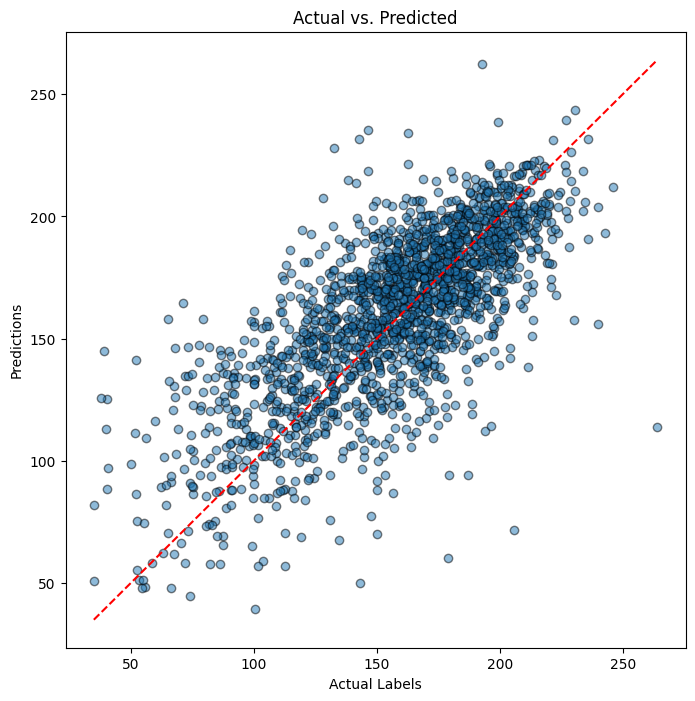

In [12]:
mlp_predictions = mlp_model.predict(mlp_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in mlp_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [10]:
test_responses = []
for _, response in mlp_test_dataset:
    test_responses.append(response.numpy())

test_responses = np.concatenate(test_responses, axis=0)

mean_train_response = tf.reduce_mean([y for _, y in mlp_train_dataset]).numpy()

baseline_loss = sum(((mean_train_response - test_responses) ** 2)/len(test_responses))
print(sum(baseline_loss))


1402.0701904296875


#### MLP + weather data

In [3]:
training_dataset, test_dataset_wo_weather, test_dataset_sat_weather  = test_train_split_multi_modal(weather_dataset, histograms_dataset, labels)

# Split the dataset
train_dataset, val_dataset = split_dataset(
    training_dataset,
    left_size=0.9,
    right_size=0.1,
    shuffle=False,
    seed=42
    )

training data shape: (6684, 1666)
test data wo weather shape: (0, 1666)
test data shape: (1408, 1666)


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Epoch 1/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7608.3789 - mae: 67.3698 - mse: 7608.3789 - val_loss: 703.7437 - val_mae: 20.8362 - val_mse: 703.7437
Epoch 2/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 680.0292 - mae: 20.1745 - mse: 680.0292 - val_loss: 599.9741 - val_mae: 18.7162 - val_mse: 599.9741
Epoch 3/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 567.6985 - mae: 18.1877 - mse: 567.6985 - val_loss: 573.0276 - val_mae: 18.2477 - val_mse: 573.0276
Epoch 4/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 507.9547 - mae: 17.0279 - mse: 507.9547 - val_loss: 541.0311 - val_mae: 18.1234 - val_mse: 541.0311
Epoch 5/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 467.7469 - mae: 16.1236 - mse: 467.7469 - val_loss: 549.5942 - val_mae: 18.3019 - val_mse: 549.5942
Epoch 6/300
187/187 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 435.1053 - mae: 15.4094 - mse: 435.1053 - val_loss: 547.7280 - val_mae: 18.4216 - val_mse: 547.7280
Epoch 7/300
187/187 ━━━━━━━━━━━━

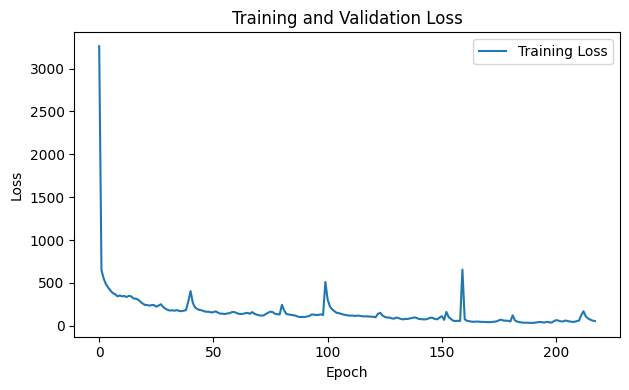

epoch/epoch,▁▁▁▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▅▄▅▄▄▃▃▃▃▄▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁█▁▁▁▁▁▁▂
epoch/mae,█▇▆▆▅▄▅▄▄▄▃▃▃▃▃▄▃▄▃▃▂▃▃▂▂▁▁▃▂▁▁▁▁▂▂▂▁▁▂▂
epoch/mse,█▅▅▄▄▃▃▃▃▃▂▃▂▂▂▂▃▂▂▂▂▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▇▇█▅▂▃▄▁▁▂▂▃▂▄▄▄▂▄▆▃▂▁▂▃▂▂▂▆▄▃▃▂▄▃▃▇▆▇▇▅
epoch/val_mae,█▅▆▃▄▂▂▃▃▂▃▂▂▃▃▁▂▃▂▁▂▂▂▂▃▂▂▂▂▂▂▂▂▂▂▂▂▃▅▂
epoch/val_mse,▆▅█▄▂▂▂▃▃▃▂▃▂▃▂▂▄▄▄▇▄▁▁▂▂▃▂▂▂▂▂▃▅▃▃▆▄▃▃▃
epoch/epoch,217
epoch/learning_rate,0.001
epoch/loss,55.64559


NameError: name 'mlp_model' is not defined

In [4]:

mlp_config = {
    "input_shape": (1666,),
    "no_units": [200] * 2 + [100] * 5,
}
mlp_model_mmodal = Mlp(**mlp_config)
mlp_model_mmodal.compile(learning_rate=0.00001, loss='mse', metrics=["mae", "mse"])
mlp_model_mmodal.fit(
    train_dataset,
    val_dataset,
    epochs=300
    )

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model_mmodal.trainable = False
wandb.finish()  

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1081.5082 - mae: 24.8870 - mse: 1081.5082
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


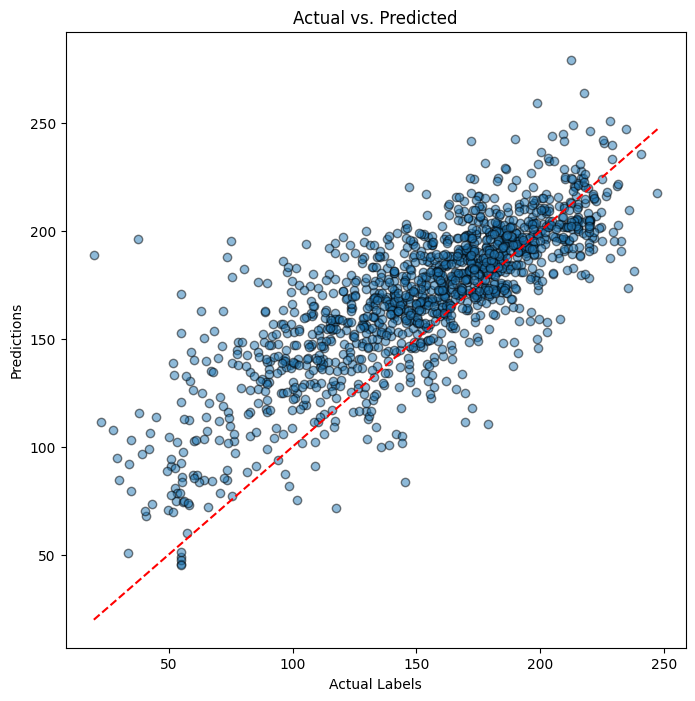

In [5]:
mlp_eval = mlp_model_mmodal.evaluate(test_dataset_sat_weather)
# print(mlp_eval)
mlp_predictions_mmodal = mlp_model_mmodal.predict(test_dataset_sat_weather)
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset_sat_weather], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions_mmodal, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

In [15]:
mlp_eval[2]**(1/2)

31.69453740271145

In [6]:
mlp_corr, mlp_p = stats.pearsonr(actual_labels.flatten(), mlp_predictions_mmodal.flatten())

print("\nCorrelations using scipy.stats.pearsonr:")
print(f"MLP correlation: {mlp_corr:.3f} (p-value: {mlp_p:.3e})")


Correlations using scipy.stats.pearsonr:
MLP correlation: 0.793 (p-value: 0.000e+00)


#### MLP on the same data

In [19]:
training_dataset, test_dataset_wo_weather, test_dataset_sat_weather  = test_train_split_multi_modal(weather_dataset, histograms_dataset, labels, include_weather_data=False)

# Split the dataset
train_dataset_wo_weather, val_dataset_wo_weather = split_dataset(
    training_dataset,
    left_size=0.9,
    right_size=0.1,
    shuffle=False,
    seed=42
    )

training data shape: (6698, 1627)
test data wo weather shape: (1383, 1627)
test data shape: (1410, 1627)


Epoch 1/300


188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7880.3335 - mae: 69.0494 - mse: 7880.3335 - val_loss: 769.7239 - val_mae: 22.1820 - val_mse: 769.7239
Epoch 2/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 774.7482 - mae: 21.6453 - mse: 774.7482 - val_loss: 622.8531 - val_mae: 19.6826 - val_mse: 622.8531
Epoch 3/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 652.4312 - mae: 19.5475 - mse: 652.4312 - val_loss: 580.6101 - val_mae: 18.8692 - val_mse: 580.6101
Epoch 4/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 596.5537 - mae: 18.4762 - mse: 596.5537 - val_loss: 567.1234 - val_mae: 18.6865 - val_mse: 567.1234
Epoch 5/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 558.5693 - mae: 17.6306 - mse: 558.5693 - val_loss: 560.4548 - val_mae: 18.5084 - val_mse: 560.4548
Epoch 6/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 526.9175 - mae: 17.0097 - mse: 526.9175 - val_loss: 542.5856 - val_mae: 18.2416 - val_mse: 542.5856
Epoch 7/300
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 

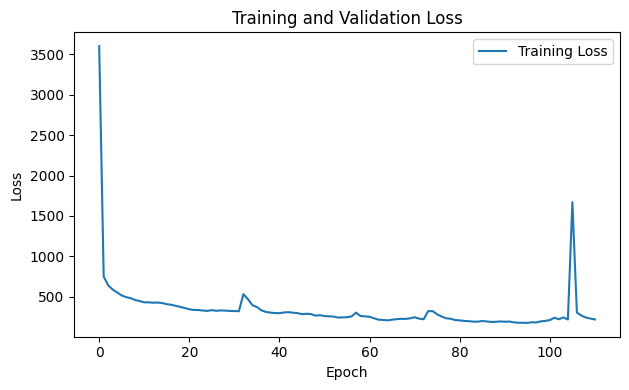

epoch/epoch,▁▁▂▂▂▁▁▂▂▂▂▂▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,▅▄▄▄▄█▇▅▄▃▃▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▃▃▃▁▁▁▁▁▁▃▂▂▂
epoch/mae,█▆▅▄█▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▄▂▁▁▁▁▁▁▁▂▂▂
epoch/mse,▇▂▂█▂▂▂▂▁▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▆▁▂▂▁▂▂▁▄█▅▃▂▂▂▃▅▃▅▂▂▄▃▄▄▅▄▄▃▃▂▂▃▂▃▃▂▃▃▂
epoch/val_mae,▂▁▃▁▂█▄▃▂▂▁▂▄▃█▂▂▄▃▅▃▄▃▃▃▅▅▄▄▂▃▂▃▃▁▃▂▁▃▂
epoch/val_mse,▁▂▂▁▂▃▂▂▂▄▇█▄▄▄▂▂▂▄▄▃▄▂▂▃▂▂▂▃▃▃▃▂▃▂▃▃▂▂▂
epoch/epoch,110
epoch/learning_rate,0.001
epoch/loss,218.67509


NameError: name 'mlp_model' is not defined

In [20]:

mlp_config = {
    "input_shape": (1627,),
    "no_units": [200] * 2 + [100] * 5,
}
mlp_model_mmodal_no_weather = Mlp(**mlp_config)
mlp_model_mmodal_no_weather.compile(learning_rate=0.00001, loss='mse', metrics=["mae", "mse"])
mlp_model_mmodal_no_weather.fit(
    train_dataset_wo_weather,
    val_dataset_wo_weather,
    epochs=300
    )

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model_mmodal_no_weather.trainable = False
wandb.finish()  

44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1300.5396 - mae: 27.0306 - mse: 1300.5396
44/44 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


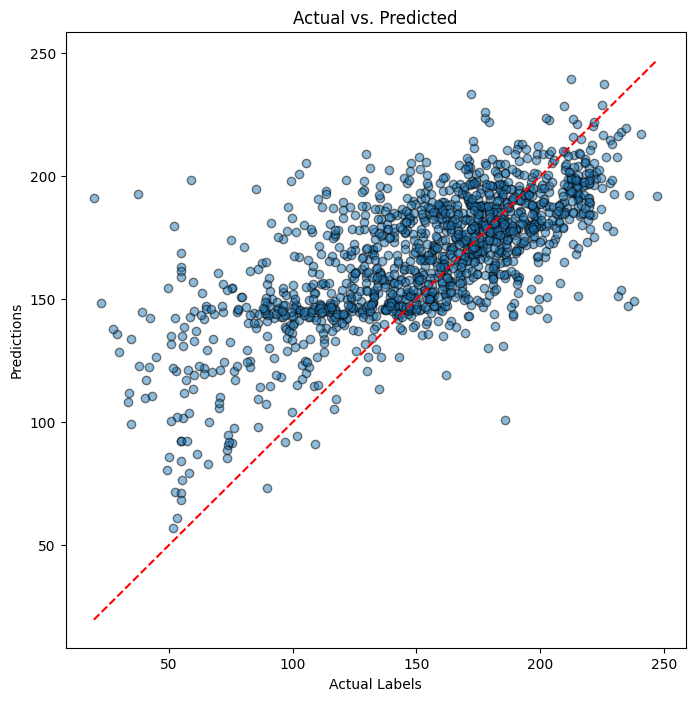

In [21]:
mlp_eval = mlp_model_mmodal_no_weather.evaluate(test_dataset_sat_weather)
# print(mlp_eval)
mlp_predictions = mlp_model_mmodal_no_weather.predict(test_dataset_sat_weather)
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset_sat_weather], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

#### MLP with only weather data

In [3]:
training_dataset_wo_sat, test_dataset_wo_weather, test_dataset_wo_sat  = test_train_split_multi_modal(weather_dataset=weather_dataset, histograms_dataset="", labels=labels)

# Split the dataset
train_dataset_wo_sat, val_dataset_wo_sat = split_dataset(
    training_dataset_wo_sat,
    left_size=0.9,
    right_size=0.1,
    shuffle=False,
    seed=42
    )

training data shape: (6608, 43)
training data head:    Temp_Max_m5  Temp_Min_m5  Temp_Median_m5  Precipitation_Total_m5  \
0      306.214      280.309        296.7760               12726.800   
1      307.256      279.059        296.7060               33483.182   
2      306.487      278.309        296.5650               24748.526   
3      306.214      280.606        297.3610                4920.546   
4      306.320      280.309        297.1025               11075.177   

   Precipitation_Median_m5  Precipitation_90th_Percentile_m5  \
0                   0.5110                            39.223   
1                   0.5785                            50.919   
2                   0.1490                            37.354   
3                   0.6560                            44.099   
4                   0.8070                            39.004   

   Precipitation_10th_Percentile_m5  Relative_Humidity_Mean_m5  \
0                               0.0                  77.550733   
1   

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: t-skorkowski. Use `wandb login --relogin` to force relogin


Epoch 1/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 11261.7725 - mae: 86.5463 - mse: 11261.7725 - val_loss: 1725.1346 - val_mae: 33.9100 - val_mse: 1725.1346
Epoch 2/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1643.6897 - mae: 31.7712 - mse: 1643.6897 - val_loss: 1486.8892 - val_mae: 30.2481 - val_mse: 1486.8892
Epoch 3/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1342.7010 - mae: 28.6413 - mse: 1342.7010 - val_loss: 1212.3214 - val_mae: 28.0739 - val_mse: 1212.3214
Epoch 4/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 1260.4890 - mae: 27.8606 - mse: 1260.4890 - val_loss: 1056.2705 - val_mae: 26.1638 - val_mse: 1056.2705
Epoch 5/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1053.3939 - mae: 25.4248 - mse: 1053.3939 - val_loss: 976.3533 - val_mae: 25.0818 - val_mse: 976.3533
Epoch 6/300
185/185 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1057.9387 - mae: 25.3901 - mse: 1057.9387 - val_loss: 1027.1151 - val_mae: 25.8841 - val_mse: 1027.1151
Epoc

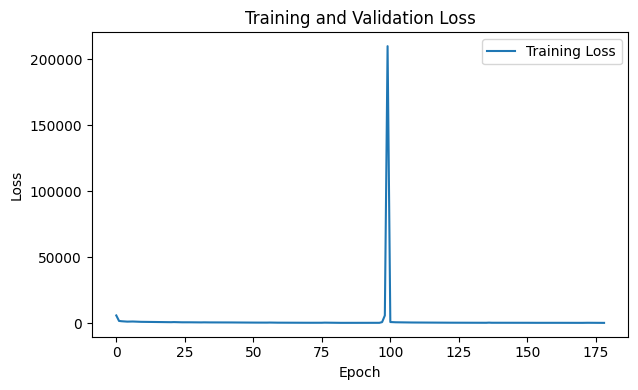

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▇▆▆▅▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁▃▂▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▃▃▃▂▃▂▂▂▂▂▂▂▂▁▁▁▁▁▂▅▂▂▂▁▁▁▁▁▂▁▁▁▁▁▁▁▁▁
epoch/mse,█▆▄▄▄▄▃▃▃▂▂▂▂▂▂▂▂▁▁▁▄▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,▆▆▅▄▅▃▂▂▃▃▄▃▄▃▁▁▂▂▂█▂▂▂▂▃▂▂▃▄▄▃▂▂▃▂▂▂▂▂▂
epoch/val_mse,█▆▅▅▅▂▄▃▄▁▁▄▂▄▃▃▄▄▂▂▂▁▄▄▃▂▂▃▂▃▃▂▄▅▄▂▂▁▂▁
epoch/epoch,178
epoch/learning_rate,0.001
epoch/loss,100.80114


NameError: name 'mlp_model' is not defined

In [4]:

mlp_config = {
    "input_shape": (43,),
    "no_units": [1024] * 2 + [500] * 3 + [50] * 2,
}
mlp_model_weeather = Mlp(**mlp_config)
mlp_model_weeather.compile(learning_rate=0.00001, loss='mse', metrics=["mae", "mse"])
mlp_model_weeather.fit(
    train_dataset_wo_sat,
    val_dataset_wo_sat,
    epochs=300
    )

# After training
original_weights = [w.numpy() for w in mlp_model.weights]

mlp_model_mmodal.trainable = False
wandb.finish()  

 1/43 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 1204.6166 - mae: 29.2221 - mse: 1204.6166

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 1512.9305 - mae: 30.5062 - mse: 1512.9305
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


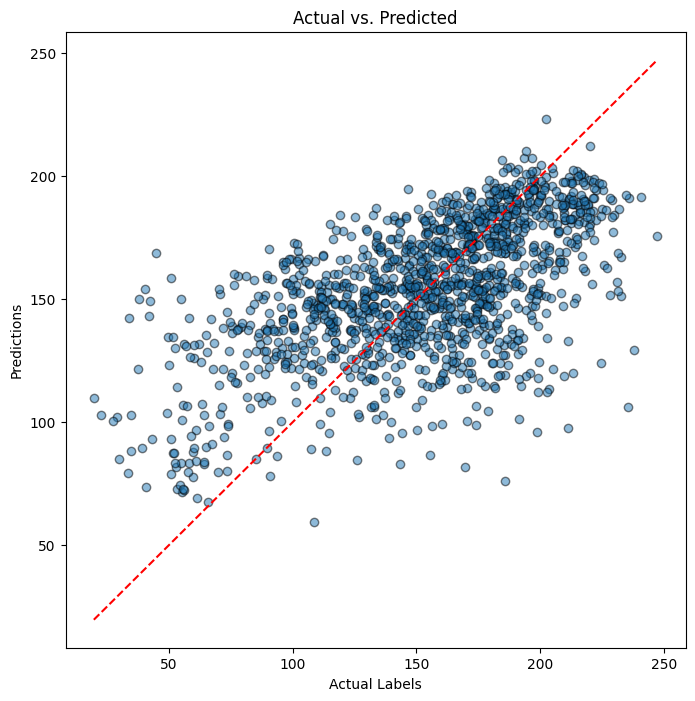

In [9]:
mlp_eval_weather_only = mlp_model_weeather.evaluate(test_dataset_wo_sat)

mlp_predictions_weather_only = mlp_model_weeather.predict(test_dataset_wo_sat)
actual_labels = np.concatenate([response.numpy() for _, response in test_dataset_wo_sat], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, mlp_predictions_weather_only, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

#### LSTM

In [11]:
lstm_dataset, labels = lstm_data_preparation(dataset_path, labels_path)
lstm_train_dataset, lstm_val_dataset, lstm_test_dataset = test_train_split(lstm_dataset,
                                                                            labels,
                                                                            **config_data)

Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - loss: 18246.0469 - mae: 127.7789 - val_loss: 6279.6826 - val_mae: 71.3393
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 4841.1128 - mae: 61.5497 - val_loss: 2200.7117 - val_mae: 39.8189
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1890.3643 - mae: 36.8602 - val_loss: 1538.1062 - val_mae: 31.9351
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1439.9133 - mae: 31.0192 - val_loss: 1483.4066 - val_mae: 30.8158
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - loss: 1399.9623 - mae: 30.0248 - val_loss: 1482.0018 - val_mae: 30.6793
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 1397.4296 - mae: 29.8793 - val_loss: 1482.1554 - val_mae: 30.6611
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 1397.2490 - mae: 29.8582 - val_loss: 1482.1743 - val_mae: 30.6595
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 27ms/step - loss: 1397.6592 - mae: 29.8580 - val_loss: 14

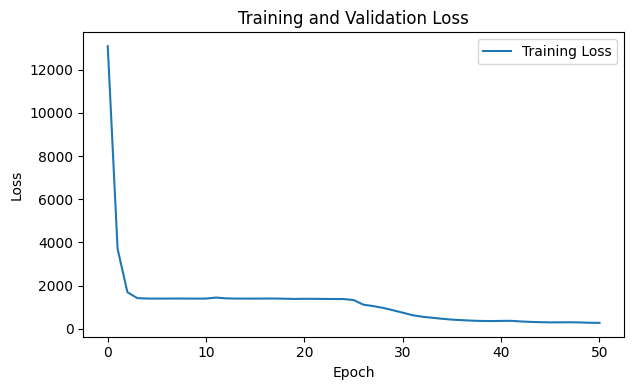

epoch/epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_mae,█▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/epoch,50
epoch/learning_rate,0.001
epoch/loss,270.24396
epoch/mae,11.00659
epoch/val_loss,693.50134


In [16]:
train_lstm = True

if train_lstm:
    wandb.init(project="blue-marble")
    config_lstm = {
        "input_shape": (config_data["months"], config_data["num_buckets"] * config_data["num_bands"]),
        "no_lstm_units": [200,] * 7,
        "attention_units": 200,
    }
    lstm_model = LstmWithAttention(**config_lstm)
    lstm_model.compile(learning_rate=0.00013)
    lstm_model.fit(lstm_train_dataset,
            lstm_val_dataset,
            epochs=300)

    lstm_model.trainable = False
    wandb.finish()
else:
    model_path = r"{PROJECT_ROOT}\1_Code_Base\models\saved\\"
    model_name = "LSTM-angry-mayo-20241101-102955.keras"
    lstm_model = tf.keras.models.load_model(model_path + model_name)
    lstm_model.compile()

In [17]:
lstm_eval = lstm_model.evaluate(lstm_test_dataset)
print(lstm_eval)

print(f"LSTM detalis: {lstm_model.summary()}")


 1/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 362.2850 - mae: 15.4977

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 623.0810 - mae: 19.2683
[656.7879638671875, 19.69952964782715]


Model: "lstm_with_attention_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (32, 3, 200)           │       593,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (32, 3, 200)           │       320,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ attention_layer_1               │ ?                      │        80,601 │
│ (AttentionLayer)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (32, 1)                │           401 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,798,208 (29.75 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,599,402 (9.92 MB)

 Optimizer params: 5,198,806 (19.83 MB)

LSTM detalis: None


#### CNN

In [20]:
config_data = {
    "months": 3,
    "num_bands": 9,
    "num_buckets": 60,
    "batch_size": 32,
}

dataset_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_dataset.npy"   
labels_path = rf"{PROJECT_ROOT}\2_Data\dataset_nan_map_True_norm_True_{config_data['num_buckets']}_buckets_{config_data['num_bands']}_bands_60_labels.npy"

In [21]:

cnn_dataset, labels = cnn_data_preparation(dataset_path, labels_path, **config_data)
cnn_train_dataset, cnn_val_dataset, cnn_test_dataset = test_train_split(cnn_dataset,
                                                                            labels,
                                                                            **config_data)

In [22]:
print(config_data["months"], config_data["num_buckets"], config_data["num_bands"], sep=", ")


3, 60, 9


Epoch 1/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 62ms/step - loss: 6701.4482 - mae: 59.2336 - val_loss: 2008.1116 - val_mae: 36.0375
Epoch 2/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 12s 63ms/step - loss: 1536.9663 - mae: 28.9408 - val_loss: 1550.3737 - val_mae: 30.7038
Epoch 3/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 1294.7762 - mae: 26.2501 - val_loss: 1387.9780 - val_mae: 28.6121
Epoch 4/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 1194.7325 - mae: 25.0882 - val_loss: 1195.0546 - val_mae: 25.8229
Epoch 5/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - loss: 1104.5787 - mae: 24.0786 - val_loss: 1123.7061 - val_mae: 24.7684
Epoch 6/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 1038.6348 - mae: 23.2256 - val_loss: 1032.4403 - val_mae: 23.2032
Epoch 7/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 991.6970 - mae: 22.6519 - val_loss: 977.3051 - val_mae: 22.0048
Epoch 8/300
191/191 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 949.9980 - mae: 22.1678 - val_loss: 

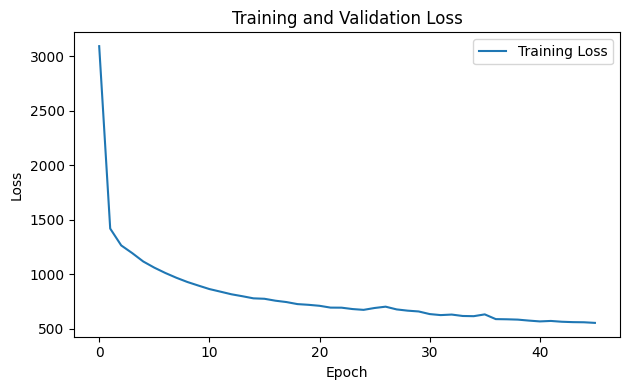

epoch/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇████
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/mae,█▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/val_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▂▂▂▁▂▁▁▂▁▁▁
epoch/val_mae,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▂▃▃▃▃▂▂▃▂▂▂▂▂▁▂▁▁▁
epoch/epoch,45
epoch/learning_rate,0.001
epoch/loss,554.95941
epoch/mae,16.12903
epoch/val_loss,814.65234


In [23]:
wandb.init(project="blue-marble")
config_cnn = {
    "input_shape": (config_data["months"], config_data["num_buckets"], config_data["num_bands"]),
    "conv_filters": [348, 128],
    "dense_units": [100] * 3,
    "conv_kernel_size": (3, 3),
    "pool_size": (2, 2),
    "dropout_rate": 0.35,
    "l1_reg": 0.03,
    "l2_reg": 0.03,

}
cnn_model = Cnn2D(**config_cnn)
cnn_model.compile(learning_rate=0.0005)
cnn_model.fit(cnn_train_dataset,
        cnn_val_dataset,
        epochs=300)

cnn_model.trainable = False
wandb.finish()

In [24]:
cnn_eval = cnn_model.evaluate(cnn_test_dataset)
print(cnn_eval)


 1/59 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - loss: 665.8854 - mae: 19.4762

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 758.6634 - mae: 19.7583
[745.0277709960938, 19.47039222717285]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


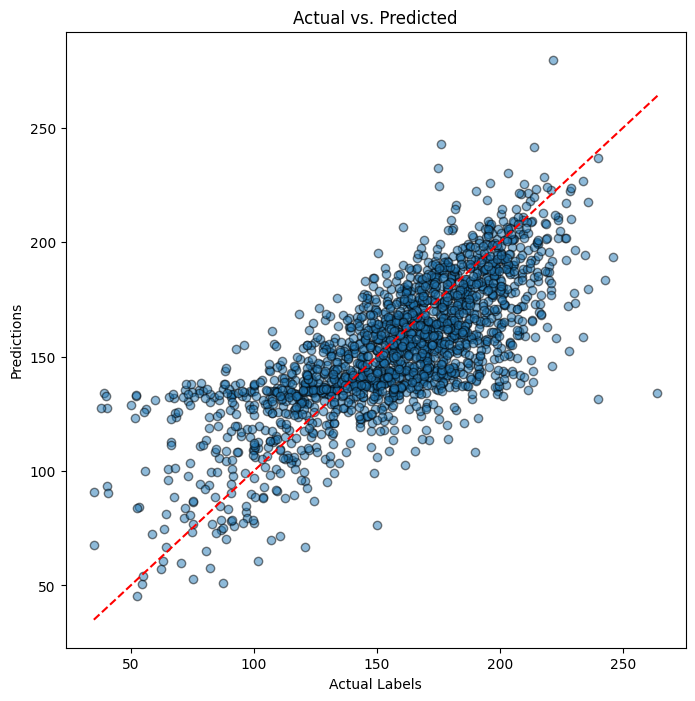


Correlations using scipy.stats.pearsonr:
CNN correlation: 0.745 (p-value: 0.000e+00)


Model: "Cnn2D-wary-chili-20241109-025544"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 348, 58, 7)       │         9,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 128, 27, 5)       │       200,576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 174, 29, 7)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 64, 13, 5)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 4160)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (32, 100)              │       416,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (32, 100)              │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 100)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (32, 1)                │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,940,165 (7.40 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 646,721 (2.47 MB)

 Optimizer params: 1,293,444 (4.93 MB)

CNN detalis: None


In [25]:
cnn_predictions = cnn_model.predict(cnn_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in cnn_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, cnn_predictions, alpha=0.5, edgecolors='k')
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.show()

cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"CNN detalis: {cnn_model.summary()}")


#### Comparison

 1/59 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step

59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


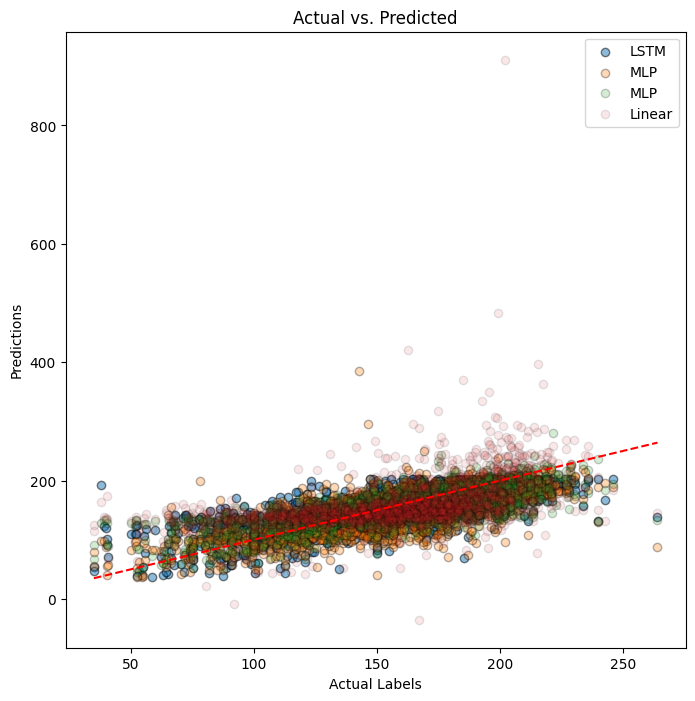


Correlations using scipy.stats.pearsonr:
MLP correlation: 0.739 (p-value: 0.000e+00)
LSTM correlation: 0.740 (p-value: 0.000e+00)
CNN correlation: 0.745 (p-value: 0.000e+00)
Mean of actual labels: 157.40


In [36]:
lstm_predictions = lstm_model.predict(lstm_test_dataset)
actual_labels = np.concatenate([response.numpy() for _, response in lstm_test_dataset], axis=0)

# Plot actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(actual_labels, lstm_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(actual_labels, mlp_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(actual_labels, cnn_predictions, alpha=0.2, edgecolors='k', label="MLP")
plt.scatter(y_test, lr_predictions, alpha=0.1, edgecolors='k', label="Linear")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

mlp_corr, mlp_p = stats.pearsonr(actual_labels.flatten(), mlp_predictions.flatten())
lstm_corr, lstm_p = stats.pearsonr(actual_labels.flatten(), lstm_predictions.flatten())
cnn_corr, cnn_p = stats.pearsonr(actual_labels.flatten(), cnn_predictions.flatten())
print("\nCorrelations using scipy.stats.pearsonr:")
print(f"MLP correlation: {mlp_corr:.3f} (p-value: {mlp_p:.3e})")
print(f"LSTM correlation: {lstm_corr:.3f} (p-value: {lstm_p:.3e})")
print(f"CNN correlation: {cnn_corr:.3f} (p-value: {cnn_p:.3e})")

print(f"Mean of actual labels: {np.mean(actual_labels):.2f}")



In [37]:
# loss below treshold
low_yield_treshold = 100
low_yeild_mask = actual_labels < low_yield_treshold

low_yield_labels = actual_labels[low_yeild_mask]
mlp_low_predictions = mlp_predictions[low_yeild_mask]
lstm_low_predictions = lstm_predictions[low_yeild_mask]
cnn_low_predictions = cnn_predictions[low_yeild_mask]

mlp_mse_low = sum((mlp_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
lstm_mse_low = sum((lstm_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)
cnn_mse_low = sum((cnn_predictions[low_yeild_mask] - actual_labels[low_yeild_mask])**2) / len(low_yeild_mask)

print(f"MLP RMSE low yield: {np.sqrt(mlp_mse_low):.2f}")
print(f"LSTM RMSE low yield: {np.sqrt(lstm_mse_low):.2f}")
print(f"CNN RMSE low yield: {np.sqrt(cnn_mse_low):.2f}")
print(f"Low yield %: {float(np.sum(low_yeild_mask)/len(low_yeild_mask)):.2%}")


MLP RMSE low yield: 8.10
LSTM RMSE low yield: 11.59
CNN RMSE low yield: 11.85
Low yield %: 8.37%


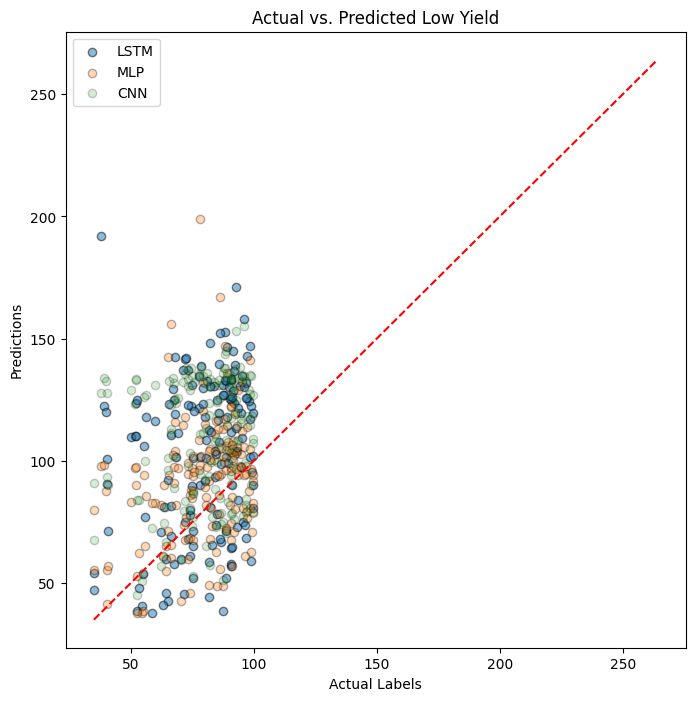

LSTM low yield crop, proportion of correctly predicted yields below the treshold: 39.24%
MLP low yield crop, proportion of correctly predicted yields below the treshold: 66.46%
CNN low yield crop, proportion of correctly predicted yields below the treshold: 36.71%


In [38]:
# Plot low yield actual vs. predicted
plt.figure(figsize=(8, 8))
plt.scatter(low_yield_labels, lstm_low_predictions, alpha=0.5, edgecolors='k', label="LSTM")
plt.scatter(low_yield_labels, mlp_low_predictions, alpha=0.3, edgecolors='k', label="MLP")
plt.scatter(low_yield_labels, cnn_low_predictions, alpha=0.2, edgecolors='k', label="CNN")
plt.xlabel('Actual Labels')
plt.ylabel('Predictions')
plt.title('Actual vs. Predicted Low Yield')
plt.plot([min(actual_labels), max(actual_labels)], [min(actual_labels), max(actual_labels)], 'r--')  # Line y=x for reference
plt.legend()
plt.show()

low_yield_lstm_low_crop = sum(lstm_low_predictions < low_yield_treshold) / len(lstm_low_predictions)
low_yield_mlp_low_crop = sum(mlp_low_predictions < low_yield_treshold) / len(mlp_low_predictions)
low_yield_cnn_low_crop = sum(cnn_low_predictions < low_yield_treshold) / len(cnn_low_predictions)

print(f"LSTM low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_lstm_low_crop:.2%}")
print(f"MLP low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_mlp_low_crop:.2%}")
print(f"CNN low yield crop, proportion of correctly predicted yields below the treshold: {low_yield_cnn_low_crop:.2%}")


#### Residuals

C:\Users\tskor\AppData\Local\Temp\ipykernel_20632\3428180465.py:7: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(residuals_for_plot, labels=labels)


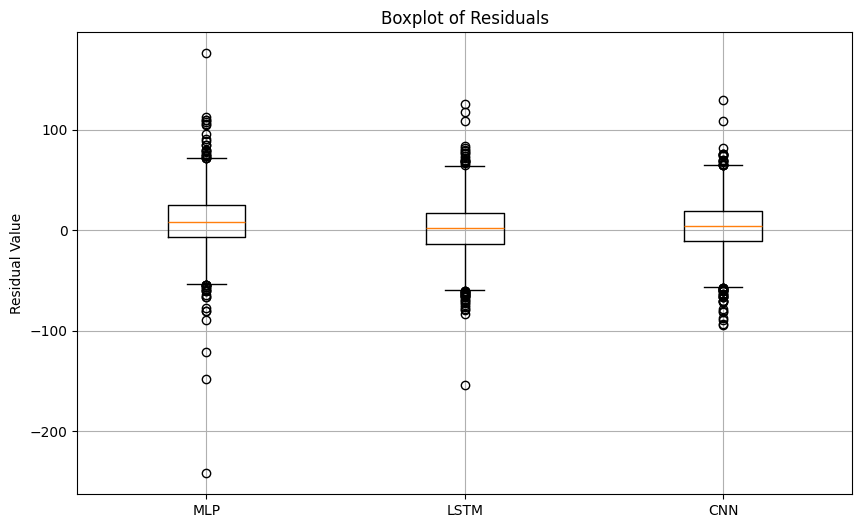

In [39]:
residuals = [actual_labels - x for x in [mlp_predictions, lstm_predictions, cnn_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
plt.boxplot(residuals_for_plot, labels=labels)
plt.title('Boxplot of Residuals')
plt.ylabel('Residual Value')
plt.grid(True)
plt.show()


Comment: 
* MLP using weighted loss function has marginally better performance on low yield data but also the highest variance

* Residuals for all models are symetrical and have mean close to 0 but they are likely not normally distributed

* Potential further improvement could come from data augmentation


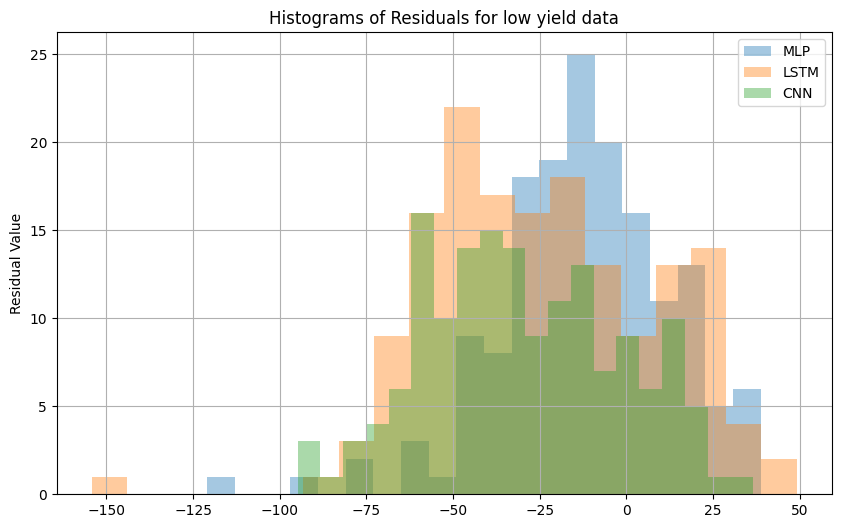

In [40]:
residuals_low_yield = [low_yield_labels - x for x in [mlp_low_predictions, lstm_low_predictions, cnn_low_predictions]]
residuals_for_plot = [residual.flatten() for residual in residuals_low_yield]

labels = ["MLP", "LSTM", "CNN"]

plt.figure(figsize=(10, 6))
for i, residual in enumerate(residuals_for_plot):
    plt.hist(residuals_for_plot[i], bins=20, alpha=0.4, label=labels[i])
    
plt.title('Histograms of Residuals for low yield data')
plt.ylabel('Residual Value')
plt.legend()
plt.grid(True)
plt.show()